# Dual LoB Correlation Analysis Phase 1

> **Business Context:** During an internal review, one of our channel teams wanted to equate seasonality trends across LoB to provide additional context into performance. This sparked several questions for me; Is there data to support this claim, or is this an assumption because they're both ***REDACTED*** brands? If they are correlated, then how strong is the correlation? Is there a lag that needs to be taken into account? **If there is a meaningful correlation, could that result in more intentional collaboration across the lines of business?**

> **Null Hypothesis:** There is no correlation between ***REDACTED*** bookings and ***REDACTED*** approvals.

> The steps taken later in the document are considered Phase 1 *(Steps 1-3 in my Analysis Plan)*, in order to see if there was enough correlation to bring in more data and continue testing. Based on the results, I concluded that there was enough correlation to continue testing.


# Analysis Plan

1.   **Data Prep**
  *   Bookings/Approvals/Spend at the Daily Level
2.   **EDA**
  *   Descriptive Statistics
  *   Simple Visualizations (Plotting time series via line graphs for initial trend spotting)
3. **Correlation Analysis**
  *   *Pearson* to explore linear relationships
  *   *Spearman* to explore monotonic relationships
4. **Granger Causality Test**
  *   Checking if past values of one time series can predict the current value of another time series
5. **Regression Analysis**
  *   Multiple regression to model the relationship between several independent variables and a dependent variable.
6. **Cross-Correlation Analysis**
  *   Cross-Correlation Function (CCF) to measure the correlation between two time series as a function of the lag of one relative to the other.
7. **Revisit Time Series Model**
  *  Vector Autoregression (VAR) seems to make the most sense here due to it's ability to model multivariate time series interdependencies


















# Data Prep

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# @title 'PATH'
df = pd.read_excel('/content/drive/MyDrive/jb_corr_analysis_full.xlsx')

In [21]:
# @title Converted Date to Datetime & Redacted Column Names
df['date'] = pd.to_datetime(df['date'])
df.rename(columns={"card_spend": "c_spend", "airways_spend": "a_spend"}, inplace = True)
df.head(10)

,date,c_spend,approvals,a_spend,bookings,approvals_log
0,2023-05-15,35657.6273,220.0959,41251.3744,8873.4276,5.394063
1,2023-05-16,35840.5503,195.0000,42189.7910,9463.0695,5.273000
2,2023-05-17,46357.9476,211.0000,39603.9696,8533.5273,5.351858
3,2023-05-18,47720.3884,238.0000,37341.2390,6944.2310,5.472271
4,2023-05-19,48061.3194,162.0000,34759.9842,6477.7961,5.087596
5,2023-05-20,43527.2201,151.0000,34171.3050,5497.5123,5.017280
6,2023-05-21,46719.1653,182.0000,35766.2580,6039.5876,5.204007
7,2023-05-22,45764.1648,208.0000,39336.6098,8332.2457,5.337538
8,2023-05-23,50661.8902,317.0000,41307.0432,8971.1541,5.758902
9,2023-05-24,43627.9930,273.0000,37908.2926,8246.5404,5.609472


In [22]:
df.tail()

,date,c_spend,approvals,a_spend,bookings,approvals_log
362,2024-05-11,15775.499311,178.0,24848.147804,5413.6654,5.181784
363,2024-05-12,16514.336505,191.0,25677.803351,6271.8712,5.252273
364,2024-05-13,16251.871334,175.0,13151.480000,6017.0000,5.164786
365,2024-05-14,16318.540752,201.0,15718.369999,7105.0000,5.303305
366,2024-05-15,16131.429493,213.0,15765.000000,6887.0000,5.361292


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           367 non-null    datetime64[ns]
 1   c_spend        367 non-null    float64       
 2   approvals      367 non-null    float64       
 3   a_spend        367 non-null    float64       
 4   bookings       367 non-null    float64       
 5   approvals_log  367 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 17.3 KB


In [24]:
df.isnull().sum()/(len(df))*100

date             0.0
c_spend          0.0
approvals        0.0
a_spend          0.0
bookings         0.0
approvals_log    0.0
dtype: float64

# EDA


In [25]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,367,2023-11-14 00:00:00.000000256,2023-05-15 00:00:00,2023-08-14 12:00:00,2023-11-14 00:00:00,2024-02-13 12:00:00,2024-05-15 00:00:00,NaN
c_spend,367.0,33163.927042,11424.570806,23870.983516,33309.244322,43172.981291,55086.5452,11215.183873
approvals,367.0,215.268597,85.7509,168.0042,209.8705,255.0,608.0,68.885391
a_spend,367.0,41772.414155,13151.48,34889.2859,41432.011496,47314.8611,83808.519613,11384.010358
bookings,367.0,7818.460045,3102.0676,6523.92235,7870.1092,9148.5017,13568.2688,1830.147296
approvals_log,367.0,5.322246,4.451447,5.123971,5.346491,5.541264,6.410175,0.318123




*   Can confirm my expected Min/Max date range came in as expected
*   Fairly even conversion distributions
*   Approval max potential outlier
*   Bookings max potential outlier




c_spend
Skew : -0.07


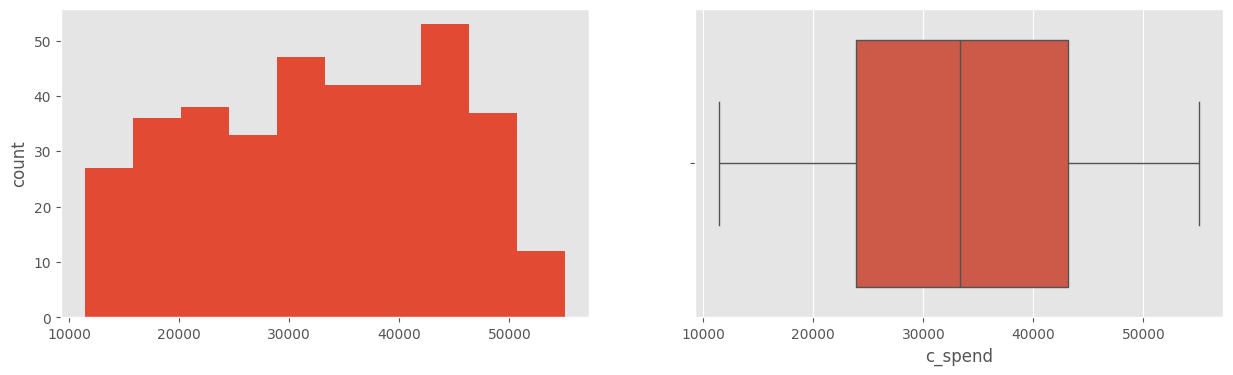

approvals
Skew : 1.03


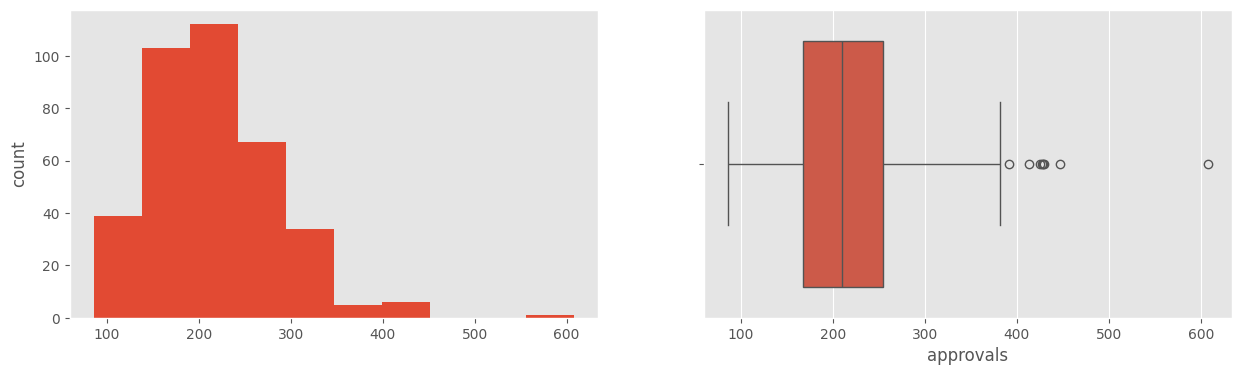

a_spend
Skew : 0.68


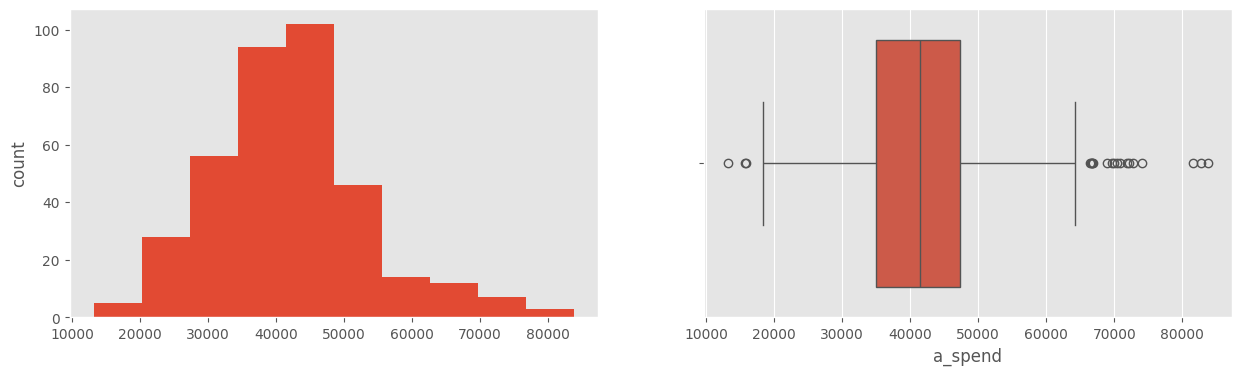

bookings
Skew : 0.06


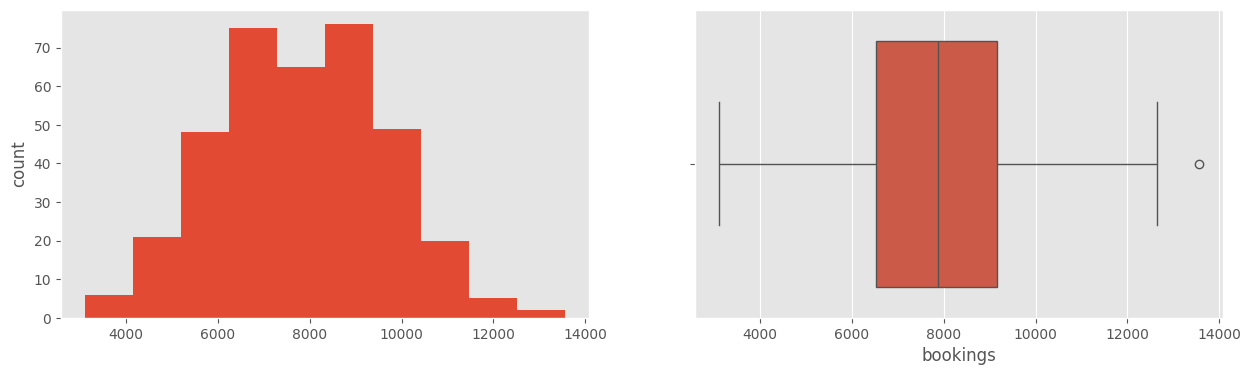

In [26]:
#Univariate Graphing

num_cols = ['c_spend', 'approvals', 'a_spend', 'bookings']

for col in num_cols:
    print(col)
    print('Skew :', round(df[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    df[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.show()

**Log transformation can help in normalization, so approvals can maintain standard scale with other variables**

In [27]:
def log_transform(df,col):
    for colname in col:
        if (df[colname] == 1.0).all():
            df[colname + '_log'] = np.log(df[colname]+1)
        else:
            df[colname + '_log'] = np.log(df[colname])
    df.info()

In [28]:
log_transform(df,['approvals'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           367 non-null    datetime64[ns]
 1   c_spend        367 non-null    float64       
 2   approvals      367 non-null    float64       
 3   a_spend        367 non-null    float64       
 4   bookings       367 non-null    float64       
 5   approvals_log  367 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 17.3 KB


<ipython-input-29-a954227ca47f>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["approvals_log"], axlabel="approvals_log");


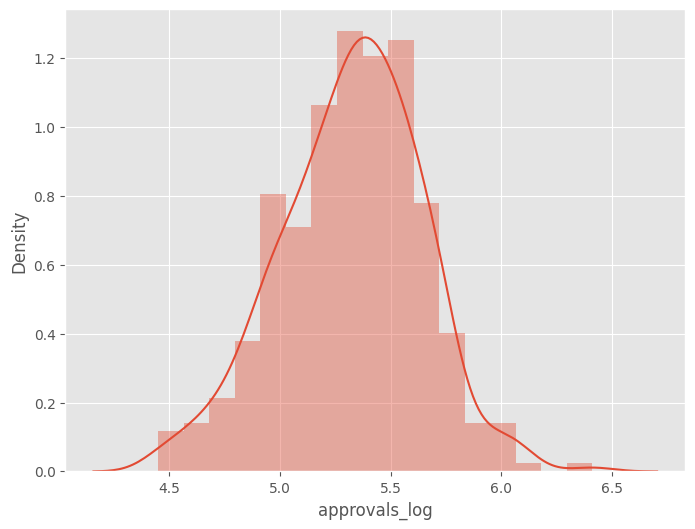

In [29]:
#Log transformation of the feature
sns.distplot(df["approvals_log"], axlabel="approvals_log");

<Figure size 1300x1700 with 0 Axes>

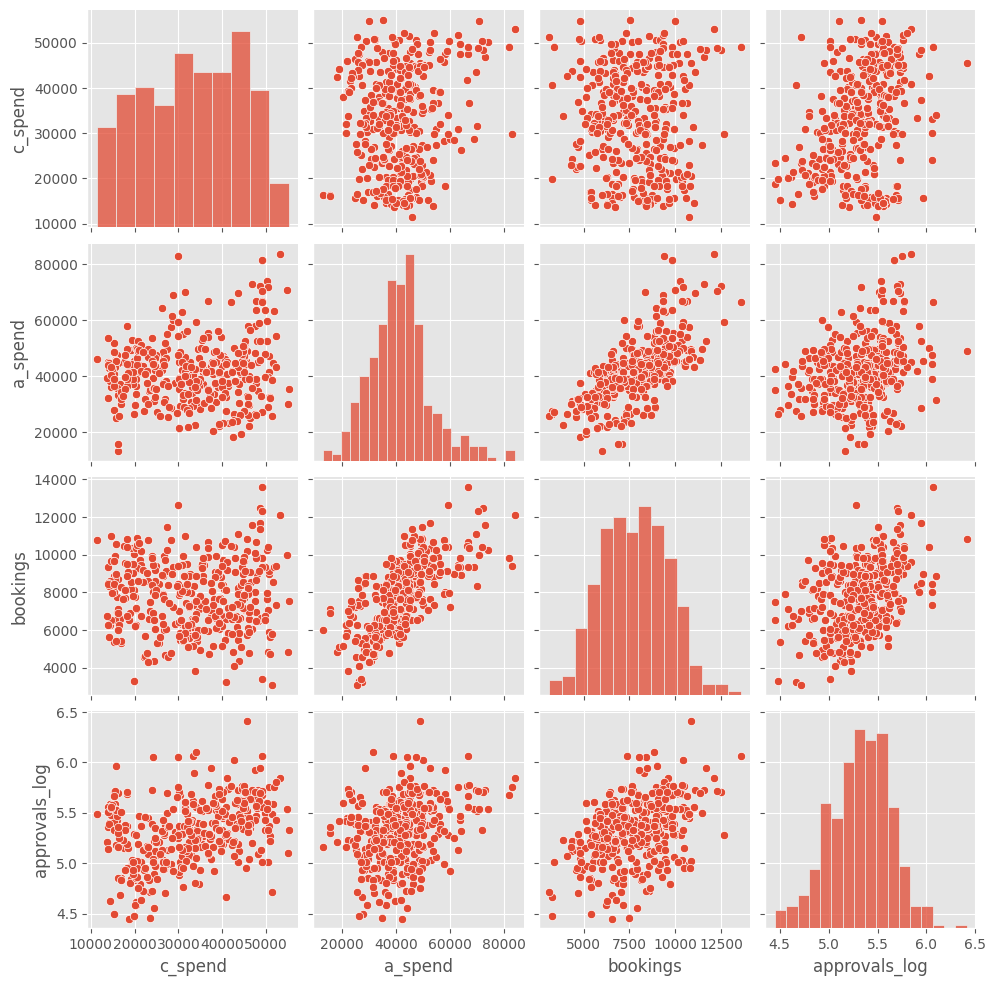

In [30]:
plt.figure(figsize=(13,17))
sns.pairplot(data=df.drop(['approvals'],axis=1))
plt.show()

<Axes: xlabel='date', ylabel='approvals_log'>

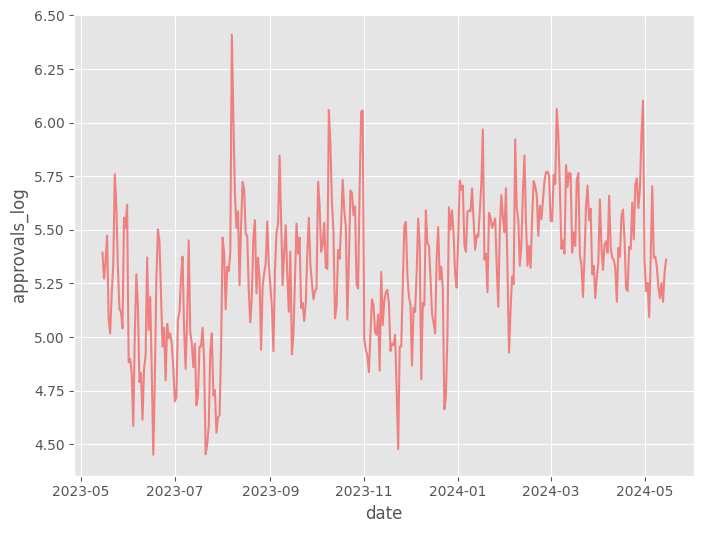

In [35]:
sns.lineplot(data=df, x="date", y="approvals_log", color="lightcoral")

<Axes: xlabel='date', ylabel='bookings'>

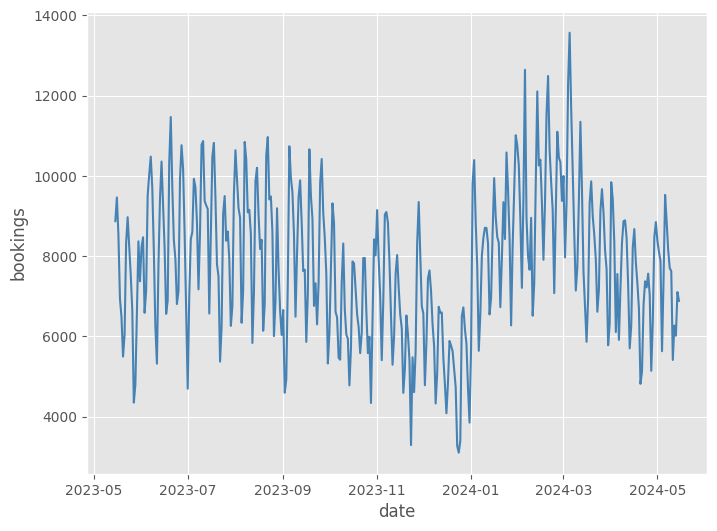

In [34]:
sns.lineplot(data=df, x="date", y="bookings", color="steelblue")

<Axes: ylabel='bookings'>

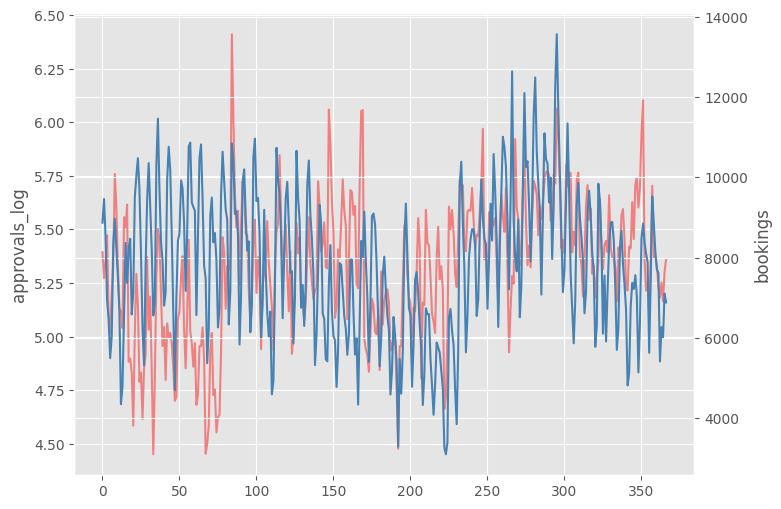

In [33]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 8,6

sns.lineplot(data=df.approvals_log, color="lightcoral")
ax2 = plt.twinx()
sns.lineplot(data=df.bookings, color="steelblue", ax=ax2)

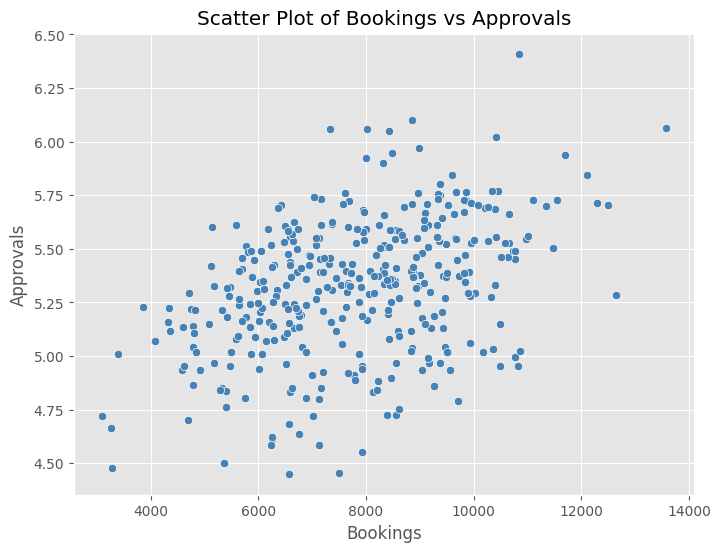

In [32]:
rcParams['figure.figsize'] = 8,6
sns.scatterplot(data=df, x='bookings', y='approvals_log', color="steelblue")
plt.title('Scatter Plot of Bookings vs Approvals')
plt.xlabel('Bookings')
plt.ylabel('Approvals')
plt.grid(True)
plt.show()


# Correlation Analysis

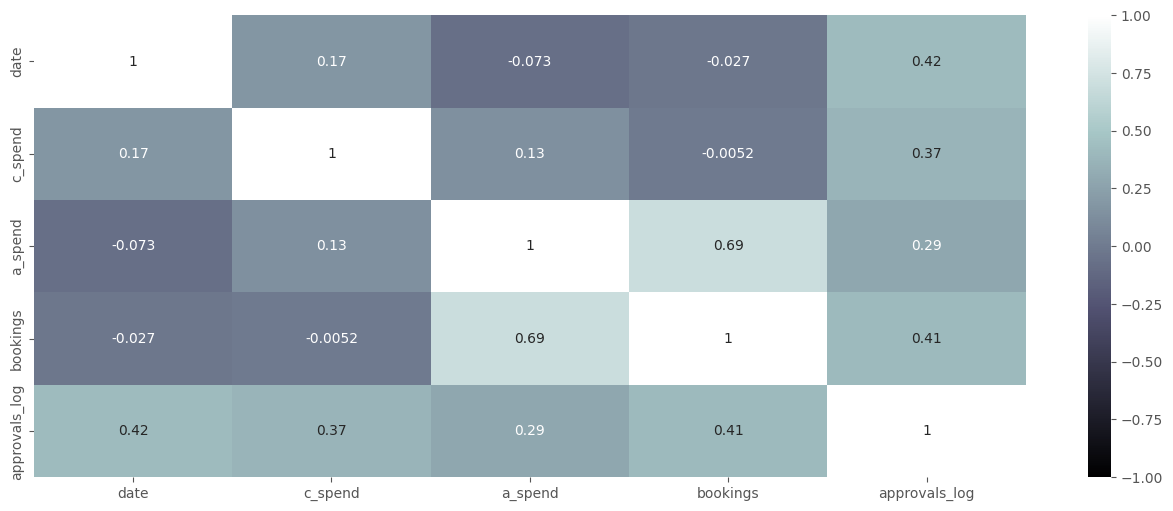

In [31]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data=df.drop(['approvals'],axis=1).corr(), vmin=-1, vmax=1, annot=True, cmap='bone')